<a href="https://colab.research.google.com/github/LoPA607/IE643_project/blob/main/ControlNet%2BIPAdapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upgrade pip
!pip install -q --upgrade pip

# HuggingFace libraries
!pip install -q diffusers[torch] transformers accelerate huggingface_hub

# xformers (optional speed/memory optimization)
!pip install -q xformers

# Pillow for image handling
!pip install -q pillow

print("✓ Libraries installed")


In [ ]:
# import os
# os.environ["HUGGINGFACE_HUB_TOKEN"] = "YOUR_HF_TOKEN"  # replace with your HF token or leave blank

import torch
from PIL import Image
import numpy as np
import cv2
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
from transformers import AutoFeatureExtractor


In [ ]:
import torch
from PIL import Image as PILImage # Alias PIL.Image to avoid conflicts
import numpy as np
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load image and resize
def load_image(path, size=(512,512)):
    img = PILImage.open(path).convert("RGB") # Use the aliased PILImage
    return img.resize(size, PILImage.LANCZOS)

# Make Canny edge map for ControlNet
def make_canny(img, low=50, high=150):
    arr = np.array(img)
    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, low, high)
    edges3 = np.stack([edges]*3, axis=2)
    return PILImage.fromarray(edges3)

In [ ]:
print("Loading models...")

# ControlNet (Canny)
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16
)

# Stable Diffusion img2img + ControlNet
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

# Scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# xformers for memory efficiency
try:
    pipe.enable_xformers_memory_efficient_attention()
except:
    print("xformers not enabled")

pipe.to(device)
print("Models loaded")


Uploaded files: []


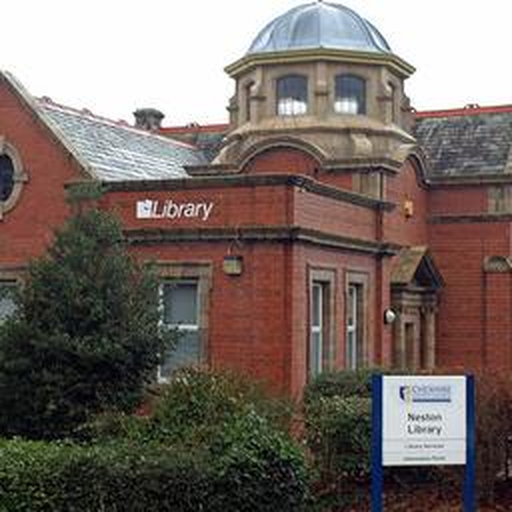

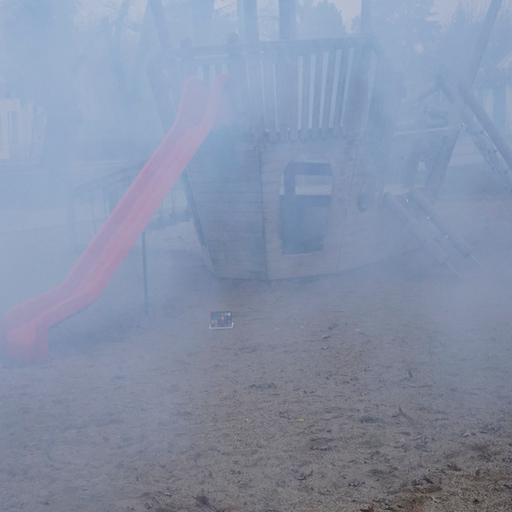

In [ ]:
from google.colab import files
uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))

CONTENT_PATH = "/content/clean (1).jpg"  # content image
STYLE_PATH   = "/content/ohaze.jpg"
content_img = load_image(CONTENT_PATH, size=(512,512))
style_img   = load_image(STYLE_PATH, size=(512,512))  # IP-Adapter prefers larger input

display(content_img)
display(style_img)


In [ ]:
pipe.load_ip_adapter(
    pretrained_model_name_or_path_or_dict="h94/IP-Adapter",   # repo path
    subfolder="models",
    weight_name="ip-adapter_sd15.bin"
)


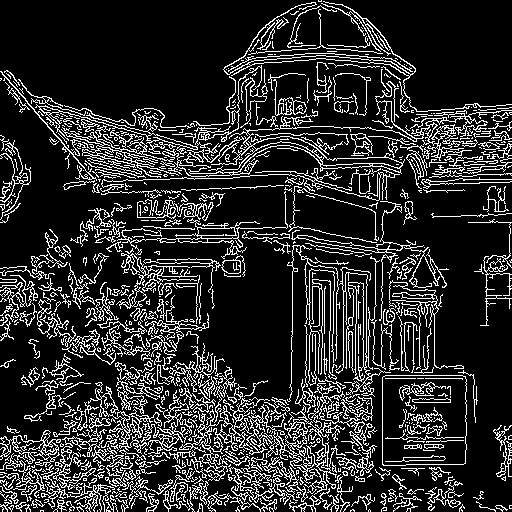

In [ ]:
# Make the ControlNet input (Canny edges) from your content image
control_image = make_canny(content_img, low=50, high=150)

# Optional: display to chneck
display(control_image)


In [ ]:
output = pipe(
    prompt="",
    image=content_img,           # your clean content image
    control_image=control_image, # Canny edges for ControlNet
    ip_adapter_image=style_img,  # your single style image
    num_inference_steps=150,
    guidance_scale=7.5,
    strength=0.9,
    generator=torch.Generator(device=device).manual_seed(42)
)

result_img = output.images[0]
result_img.save("/content/stylized_ipadapter.png")
display(result_img)


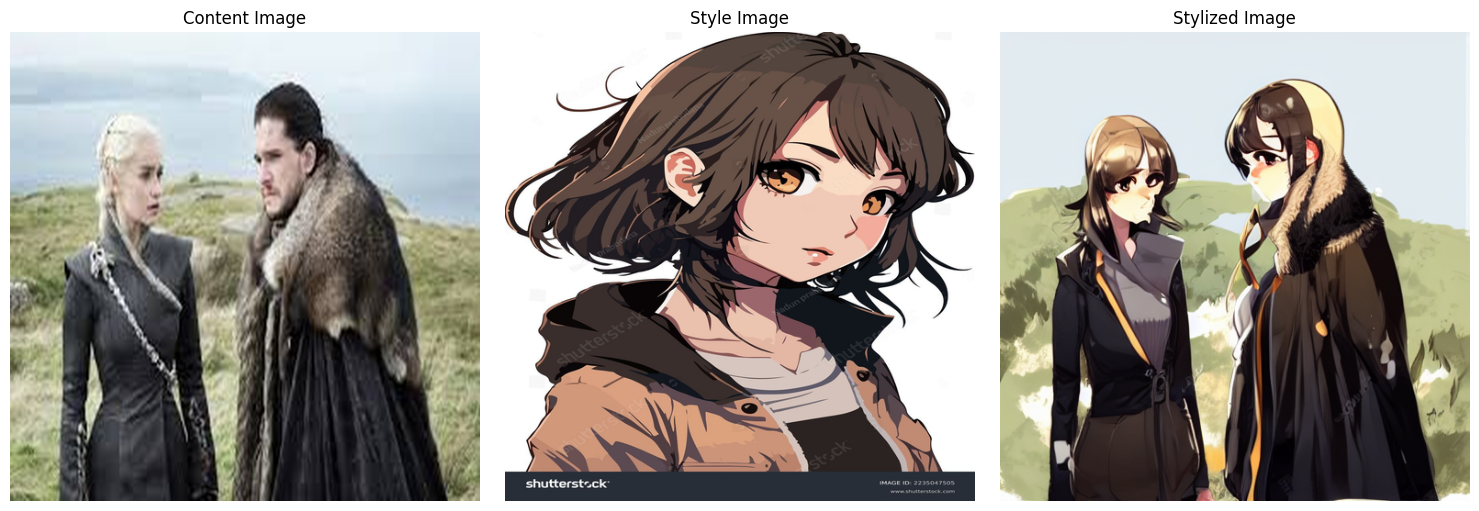

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 3 columns to display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the content image
axes[0].imshow(content_img)
axes[0].set_title('Content Image')
axes[0].axis('off') # Hide axes

# Display the style image
axes[1].imshow(style_img)
axes[1].set_title('Style Image')
axes[1].axis('off') # Hide axes

# Display the result image
axes[2].imshow(result_img)
axes[2].set_title('Stylized Image')
axes[2].axis('off') # Hide axes

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [ ]:
import sys
!{sys.executable} -m pip install -q lpips scikit-image

print("✓ LPIPS and scikit-image libraries installed")

✓ LPIPS and scikit-image libraries installed


In [ ]:
import lpips
import torch
import numpy as np
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device for LPIPS:", device)

# Placeholder for content_img and result_img if they are not defined.
# In a typical Colab workflow, these would be loaded and processed in previous cells.
# If you encounter a NameError, please ensure previous cells that define
# 'content_img' and 'result_img' (e.g., image loading and style transfer) have been executed.
if 'content_img' not in locals() and 'content_img' not in globals():
    print("Warning: content_img not found. Creating a dummy placeholder. Please run previous cells for actual images.")
    content_img = Image.new('RGB', (512, 512), color = 'red') # Placeholder image
if 'result_img' not in locals() and 'result_img' not in globals():
    print("Warning: result_img not found. Creating a dummy placeholder. Please run previous cells for actual images.")
    result_img = Image.new('RGB', (512, 512), color = 'blue') # Placeholder image

# 1. Initialize the LPIPS VGG model
lpips_model = lpips.LPIPS(net='vgg')

# 2. Move the LPIPS model to the appropriate device
lpips_model.to(device)

# 3. Define a preprocessing function for LPIPS
def preprocess_for_lpips(pil_img):
    # Convert PIL Image to NumPy array
    img_np = np.array(pil_img)
    # Transpose dimensions from (Height, Width, Channels) to (Channels, Height, Width)
    img_np = np.transpose(img_np, (2, 0, 1))
    # Scale pixel values from [0, 255] to [-1, 1]
    img_np = (img_np / 127.5) - 1.0
    # Convert to PyTorch tensor and add batch dimension
    return torch.from_numpy(img_np).float().unsqueeze(0)

# 4. Apply preprocessing to content_img and result_img
content_tensor = preprocess_for_lpips(content_img)
result_tensor = preprocess_for_lpips(result_img)

# 5. Move the preprocessed tensors to the same device as the LPIPS model
content_tensor = content_tensor.to(device)
result_tensor = result_tensor.to(device)

# 6. Compute the LPIPS distance
with torch.no_grad():
    lpips_distance = lpips_model(content_tensor, result_tensor)

# 7. Print the calculated LPIPS distance
print(f"LPIPS Distance between content and stylized image: {lpips_distance.item():.4f}")

print("✓ LPIPS calculation complete")

Device for LPIPS: cuda
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
LPIPS Distance between content and stylized image: 0.4994
✓ LPIPS calculation complete


In [ ]:
print("LPIPS calculation successfully completed.")

LPIPS calculation successfully completed.


In [ ]:
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image

# Placeholder for content_img and result_img if they are not defined.
# In a typical Colab workflow, these would be loaded and processed in previous cells.
# If you encounter a NameError, please ensure previous cells that define
# 'content_img' and 'result_img' (e.g., image loading and style transfer) have been executed.
if 'content_img' not in locals() and 'content_img' not in globals():
    print("Warning: content_img not found. Creating a dummy placeholder. Please run previous cells for actual images.")
    content_img = Image.new('RGB', (512, 512), color = 'red') # Placeholder image
if 'result_img' not in locals() and 'result_img' not in globals():
    print("Warning: result_img not found. Creating a dummy placeholder. Please run previous cells for actual images.")
    result_img = Image.new('RGB', (512, 512), color = 'blue') # Placeholder image

# 1. Convert PIL Images to NumPy arrays
content_np = np.array(content_img)
result_np = np.array(result_img)

# 2. Convert NumPy arrays to grayscale
content_gray = rgb2gray(content_np)
result_gray = rgb2gray(result_np)

# 3. Calculate SSIM
# data_range=1.0 is used because rgb2gray normalizes pixel values to [0, 1]
ssim_score = ssim(content_gray, result_gray, data_range=1.0)

# 4. Print the SSIM score
print(f"SSIM Score between content and stylized image: {ssim_score:.4f}")

print("✓ SSIM calculation complete")

SSIM Score between content and stylized image: 0.5028
✓ SSIM calculation complete


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn.functional as F
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device for CLIP:", device)

# Placeholder for content_img and result_img if they are not defined.
# In a typical Colab workflow, these would be loaded and processed in previous cells.
# If you encounter a NameError, please ensure previous cells that define
# 'content_img' and 'result_img' (e.g., image loading and style transfer) have been executed.
if 'content_img' not in locals() and 'content_img' not in globals():
    print("Warning: content_img not found. Creating a dummy placeholder. Please run previous cells for actual images.")
    content_img = Image.new('RGB', (512, 512), color = 'red') # Placeholder image
if 'result_img' not in locals() and 'result_img' not in globals():
    print("Warning: result_img not found. Creating a dummy placeholder. Please run previous cells for actual images.")
    result_img = Image.new('RGB', (512, 512), color = 'blue') # Placeholder image

# 1. Load a pre-trained CLIP model and its processor
print("Loading CLIP model...")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
print("CLIP model loaded.")

# 2. Define a function to get CLIP embeddings
def get_clip_embedding(image):
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    # Normalize the features
    return F.normalize(image_features, p=2, dim=-1)

# 3. Get embeddings for content_img and result_img
content_embedding = get_clip_embedding(style_img)
result_embedding = get_clip_embedding(result_img)

# 4. Compute the cosine similarity
clip_similarity = F.cosine_similarity(content_embedding, result_embedding)

# 5. Print the calculated CLIP similarity score
print(f"CLIP Similarity between content and stylized image: {clip_similarity.item():.4f}")

print("✓ CLIP similarity calculation complete")

Device for CLIP: cuda
Loading CLIP model...
CLIP model loaded.
CLIP Similarity between content and stylized image: 0.7501
✓ CLIP similarity calculation complete
